In [1]:
import tensorflow as tf
import numpy as np
from bptt import BPTT
import matplotlib.pyplot as plt
from tensorflow.python import debug as tf_debug
%load_ext autotime
%matplotlib inline 

In [2]:
tf.reset_default_graph()

time: 2 ms


In [3]:
def softmax_pooling(x):
    coefs = tf.nn.softmax(x, dim = -1)
    softmax_pool = tf.reduce_sum(tf.multiply(coefs, x), axis = -1)
    return softmax_pool

time: 2.29 ms


In [4]:
class PhysicalNet: 
    
    def __init__(self, layer_sizes, input_size, output_size, keep_prob = 0.9, stddev = 0.0001):
        self.nb_layers = len(layer_sizes)
        self.layer_sizes = layer_sizes
        self.input_size = input_size
        self.output_size = output_size
        self.stddev = stddev
        
        self.Weights = []
        self.Biases = []
        
        self.init_weights()
        self.init_biases()
        
    def init_weights(self):
        with tf.variable_scope("phys_variable") as scope:
            for i in range(self.nb_layers):
                if i == 0:
                    #W = tf.Variable(tf.random_normal([self.layer_sizes[i], self.input_size], stddev = self.stddev), name = "weight_" + str(i))
                    W = tf.get_variable("weight_" + str(i), shape=[self.layer_sizes[i], self.input_size],
                                        initializer=tf.contrib.layers.xavier_initializer(False))
                    tf.summary.histogram('phys_net_weight_'+ str(i), W)
                elif i != (self.nb_layers - 1):
                    W = tf.get_variable("weight_" + str(i), shape=[self.layer_sizes[(i+1)], self.layer_sizes[i]],
                                        initializer=tf.contrib.layers.xavier_initializer(False))
                    #W = tf.Variable(tf.random_normal([self.layer_sizes[(i+1)], self.layer_sizes[i]], stddev = self.stddev), name = "weight_" + str(i))
                    tf.summary.histogram('phys_net_weight_'+ str(i), W)
                else:
                    W = tf.get_variable("weight_" + str(i), shape=[self.output_size, self.layer_sizes[i]],
                                        initializer=tf.contrib.layers.xavier_initializer(False))
                    #W = tf.Variable(tf.random_normal([self.output_size, self.layer_sizes[i]], stddev = self.stddev), name = "weight_" + str(i))
                    tf.summary.histogram('phys_net_weight_'+ str(i), W)

                self.Weights.append(W)
            
    def init_biases(self):
        with tf.variable_scope("phys_variable") as scope:
            for i in range(self.nb_layers):
                #B = tf.Variable(tf.random_normal([self.layer_sizes[i], 1], stddev = self.stddev), name = "bias_" + str(i))
                B = tf.get_variable("bias_" + str(i), shape=[self.layer_sizes[i], 1],
                                        initializer=tf.contrib.layers.xavier_initializer(False))
                tf.summary.histogram('phys_net_bias_'+ str(i), B)
                self.Biases.append(B)
            
            
    def compute_output(self, x): ## ADD THE DROPOUTS ## ADD THE SOFTMAX AT THE END ?
            for i in range(self.nb_layers):
                W = self.Weights[i]
                b = self.Biases[i]
                if i != (self.nb_layers - 1):
                    x = tf.nn.dropout(tf.nn.elu(tf.matmul(W, x) + b), keep_prob = 0.9)
                else:
                    x = tf.nn.elu(tf.matmul(W, x) + b)
            
            return x

time: 60.8 ms


In [5]:
class CommunicationNet: ## ADD THE MEMORY !! 
    
    def __init__(self, layer_sizes, input_size, keep_prob = 0.9, memory_size = 32,
                 stddev_epsilon = 0.35, output_size = 256, stddev = 0.0001):
        self.nb_layers = len(layer_sizes)
        self.layer_sizes = layer_sizes
        self.input_size = input_size
        self.memory_size = memory_size
        self.stddev_epsilon = stddev_epsilon
        self.output_size = output_size
        self.stddev = stddev
        
        self.Weights = []
        self.Biases = []
        self.Weight_read_mem = tf.Variable(tf.random_normal([self.layer_sizes[(self.nb_layers-1)], self.memory_size]
                                                            ,stddev = self.stddev))
        
        self.init_weights()    
        self.init_biases()
        self.def_delta_mem()
        
        
    def init_weights(self):
        with tf.variable_scope("com_variable") as scope:
            for i in range(self.nb_layers):
                if i == 0:
                    W = tf.get_variable("com_net_weight_" + str(i), shape=[self.layer_sizes[i], self.input_size],
                                        initializer=tf.contrib.layers.xavier_initializer(False))
                    #W = tf.Variable(tf.random_normal([self.layer_sizes[i], self.input_size], stddev = self.stddev), name = "weight_" + str(i))
                    tf.summary.histogram('com_net_weight_'+ str(i), W)
                elif i != (self.nb_layers - 1):
                    W = tf.get_variable("com_net_weight_" + str(i), shape=[self.layer_sizes[(i+1)], self.layer_sizes[i]],
                                        initializer=tf.contrib.layers.xavier_initializer(False))
                    #W = tf.Variable(tf.random_normal([self.layer_sizes[(i+1)], self.layer_sizes[i]],stddev = self.stddev), name = "weight_" + str(i))
                    tf.summary.histogram('com_net_weight_'+ str(i), W)
                else:
                    W = tf.get_variable("com_net_weight_" + str(i), shape=[self.output_size, self.layer_sizes[i]],
                                        initializer=tf.contrib.layers.xavier_initializer(False))
                    #W = tf.Variable(tf.random_normal([self.output_size, self.layer_sizes[i]],stddev = self.stddev), name = "weight_" + str(i))
                    tf.summary.histogram('com_net_weight_'+ str(i), W)

                self.Weights.append(W)
       
    
    def init_biases(self):
        with tf.variable_scope("com_variable") as scope:
            for i in range(self.nb_layers):
                #B = tf.Variable(tf.random_normal([self.layer_sizes[i], 1],stddev = self.stddev), name = "bias_" + str(i))
                B = tf.Variable(tf.zeros([self.layer_sizes[i], 1]), name = "com_net_bias_" + str(i))
                tf.summary.histogram('com_net_bias_'+ str(i), B)
                self.Biases.append(B)
       
    
    def def_delta_mem(self):
        #self.W_mem = tf.Variable(tf.random_normal(shape =[self.memory_size,self.output_size],stddev = self.stddev), name = "weight_mem_com")
        self.W_mem = tf.get_variable("weight_mem_com" , shape=[self.memory_size,self.output_size],
                            initializer=tf.contrib.layers.xavier_initializer(False))
        self.b_mem = tf.Variable(tf.zeros(shape = [self.memory_size, 1]), name = "bias_mem_com")

        
    def compute_output(self, x, memory):## ADD THE DROPOUTS AND SOFTMAX ?
        for i in range(self.nb_layers):
            W = self.Weights[i]
            b = self.Biases[i]
            if i != (self.nb_layers - 1):
                x = tf.nn.dropout(tf.nn.elu(tf.matmul(W, x) + b), keep_prob = 0.9)
            else:
                x = tf.nn.elu(tf.matmul(W, x) + tf.matmul(self.Weight_read_mem, memory) + b)
                
            
        delta_mem = tf.add(tf.matmul(self.W_mem, x),self.b_mem)
        return x, delta_mem

time: 90.7 ms


In [6]:
class LastNet: ## ADD THE MEMORY !! The memory initialization is random ==> set it 0
    
    def __init__(self, layer_sizes, input_size, keep_prob = 0.9, memory_size = 32, 
                 stddev_epsilon = 0.35, output_size = 24, stddev = 0.0001):
        self.nb_layers = len(layer_sizes)
        self.layer_sizes = layer_sizes
        self.input_size = input_size
        self.memory_size = memory_size
        self.stddev_epsilon = stddev_epsilon
        self.output_size = output_size
        self.stddev = stddev
        
        self.Weights = []
        self.Biases = []
        self.Weight_read_mem = tf.Variable(tf.random_normal([self.output_size, self.memory_size],stddev = self.stddev))
        
        self.init_weights()    
        self.init_biases()
        self.def_delta_mem()
        
        
    def init_weights(self):
        with tf.variable_scope("last_variable") as scope:
            for i in range(self.nb_layers):
                if i == 0:
                    W = tf.get_variable("lastnet_weight_" + str(i), shape=[self.layer_sizes[i], self.input_size],
                                        initializer=tf.contrib.layers.xavier_initializer(False))
                    #W = tf.Variable(tf.random_normal([self.layer_sizes[i], self.input_size],stddev = self.stddev), name = "weight_" + str(i))
                    tf.summary.histogram('last_net_weight_'+ str(i), W)
                elif i != (self.nb_layers - 1):
                    W = tf.get_variable("last_net_weight_" + str(i), shape=[self.layer_sizes[(i+1)], self.layer_sizes[i]],
                                        initializer=tf.contrib.layers.xavier_initializer(False))
                    #W = tf.Variable(tf.random_normal([self.layer_sizes[(i+1)], self.layer_sizes[i]],stddev = self.stddev), name = "weight_" + str(i))
                    tf.summary.histogram('last_net_weight_'+ str(i), W)
                else:
                    W = tf.get_variable("last_net_weight_" + str(i), shape=[self.output_size, self.layer_sizes[i]],
                                        initializer=tf.contrib.layers.xavier_initializer(False))
                    #W = tf.Variable(tf.random_normal([self.output_size, self.layer_sizes[i]],stddev = self.stddev), name = "weight_" + str(i))
                    tf.summary.histogram('last_net_weight_'+ str(i), W)

                self.Weights.append(W)
            
    def init_biases(self):
        with tf.variable_scope("last_variable") as scope:
            for i in range(self.nb_layers):
                if i != (self.nb_layers - 1):
                    #B = tf.Variable(tf.random_normal([self.layer_sizes[i+1], 1],stddev = self.stddev), name = "bias_" + str(i))
                    B = tf.Variable(tf.zeros([self.layer_sizes[i], 1]), name = "last_net_bias_" + str(i))
                    tf.summary.histogram('last_net_bias_'+ str(i), B)
                else:
                    #B = tf.Variable(tf.random_normal([self.output_size, 1], stddev = self.stddev), name = "bias_" + str(i))
                    B = tf.Variable(tf.zeros([self.output_size, 1]), name = "last_net_bias_" + str(i))
                    tf.summary.histogram('last_net_bias_'+ str(i), B)

                self.Biases.append(B)

        
    def def_delta_mem(self):
        #self.W_mem = tf.Variable(tf.random_normal(shape =[self.memory_size,self.output_size],stddev = self.stddev),
        #                        name = "weight_mem_last")
        self.W_mem = tf.get_variable("weight_mem_last", shape=[self.memory_size,self.output_size],
                                initializer=tf.contrib.layers.xavier_initializer(False))
        self.b_mem = tf.Variable(tf.zeros(shape = [self.memory_size, 1]),
                                name = "bias_mem_last")
        
    def compute_output(self, x, memory):## ADD THE DROPOUTS !!! REMOVE THE SOFTMAX OF THE LAST LAYER !!!
        for i in range(self.nb_layers):
            W = self.Weights[i]
            b = self.Biases[i]
            if i != (self.nb_layers - 1):
                x = tf.nn.dropout(tf.nn.elu(tf.matmul(W, x) + b), keep_prob = 0.9)
            else:
                x = tf.nn.elu(tf.matmul(W, x) + tf.matmul(self.Weight_read_mem, memory) + b)
               
        delta_mem = tf.add(tf.matmul(self.W_mem, x),self.b_mem)
        return x, delta_mem

time: 93.5 ms


In [7]:
class Policy_Phys:
    
    def __init__(self, nb_agent, nb_landmark, hidden_layer_size = 256, env_dim = 2, 
                 batch_size = 1024, stddev_phys_output = 0.0001):
        self.stddev_phys_output = stddev_phys_output
        self.batch_size = batch_size
        self.env_dim = env_dim
        self.nb_agent = nb_agent
        self.nb_landmark = nb_landmark
        self.hidden_layer_size = hidden_layer_size
        
        self.init_all()
        
    def init_phys_module(self):
        self.network_phys = PhysicalNet([self.hidden_layer_size, self.hidden_layer_size, self.hidden_layer_size], 
                                              self.env_dim, self.hidden_layer_size)


    def compute_output(self, x_agent):
        output = []
        for x in x_agent:
            output.append(tf.reshape(self.network_phys.compute_output(x), [256, -1, 1]))
            
        all_phys_output = tf.concat(output, axis = 2)
        self.PhiX = softmax_pooling(all_phys_output)
        return self.PhiX

    def init_all(self):
        self.init_phys_module()

time: 20.2 ms


In [8]:
class Policy_Utterance:
    
    def __init__(self, nb_agent, goal_size, vocabulary_size = 20, 
                 hidden_layer_size = 256, memory_size = 32, temperature = 1, batch_size = 1024,
                 stddev_phys_output = 0.0001):
        self.size_goal = goal_size
        self.nb_agent = nb_agent
        self.stddev_phys_output = stddev_phys_output
        self.batch_size = batch_size
        self.temperature = temperature
        self.memory_size = memory_size
        self.vocabulary_size = vocabulary_size
        self.hidden_layer_size = hidden_layer_size
        self.goal = tf.placeholder(tf.float32, [self.size_goal, None])
        
        self.init_all()
        

    def init_com_module(self):## Les poids seront les mêmes pour tous les agents
        self.network_com = CommunicationNet([self.hidden_layer_size, self.hidden_layer_size, self.hidden_layer_size], 
                                             self.vocabulary_size)


    def init_all(self):
        self.init_com_module()

    def compute_output(self, c_agent, mem_agent):
        output = []
        delta_mem = []
        for c, mem in zip(c_agent, mem_agent):
            o, m = self.network_com.compute_output(c, mem)
            output.append(tf.reshape(o, [256, -1, 1]))
            delta_mem.append(m)

        all_comm_output = tf.concat(output, axis = 2)
        PhiC = softmax_pooling(all_comm_output)
        
        return PhiC, delta_mem

time: 35.4 ms


In [9]:
class Policy_Last:
    
    def __init__(self, hidden_layer_size = 256, size_goal = 8, memory_size = 32, batch_size = 1024, 
                 stddev_phys_output = 0.0001, vocabulary_size = 20, env_dim = 2, temperature = 1):
        self.temperature = temperature
        self.stddev_phys_output = stddev_phys_output
        self.env_dim = env_dim
        self.vocabulary_size = vocabulary_size 
        self.batch_size = batch_size
        self.memory_size = memory_size
        self.hidden_layer_size = hidden_layer_size
        self.size_goal = size_goal
        self.init_all()

    def init_last_module(self):
        inp_size = (2*self.hidden_layer_size + self.size_goal)
        out_size = self.vocabulary_size + 2*self.env_dim
        self.last_net = LastNet([self.hidden_layer_size, self.hidden_layer_size, self.hidden_layer_size], 
                                inp_size, output_size = out_size)

    def init_all(self):
        self.init_last_module()

    def sample_utterance(self, output):## Vérifier qu'on prend un bon slice sur l'output
        u = -tf.log(-tf.log(tf.random_uniform(shape = [self.vocabulary_size, self.batch_size],dtype=tf.float32)))
        utterance_output = tf.slice(output, [2*self.env_dim, 0], [self.vocabulary_size, self.batch_size])
        gumbel = tf.exp((utterance_output + u)/self.temperature)
        denoms = tf.reduce_sum(gumbel, axis = 0)
        utterance = gumbel/denoms
        return utterance
        
    def sample_phys(self, output):
        u = tf.random_normal(shape = [2*self.env_dim, self.batch_size],dtype=tf.float32, stddev = self.stddev_phys_output)
        o = tf.add(tf.slice(output, [0, 0], [2*self.env_dim, self.batch_size]), u)
        sample_move = tf.slice(o, [0, 0], [self.env_dim, self.batch_size])
        sample_gaze  = tf.slice(o, [self.env_dim, 0], [self.env_dim, self.batch_size])
        return sample_move, sample_gaze
            
    def compute_output(self, PhiX, PhiC, last_mem, goal):
        Phi = tf.concat([PhiX, goal, PhiC], axis = 0)
        output, memory = self.last_net.compute_output(Phi, last_mem)
        utterance = self.sample_utterance(output)
        move, gaze = self.sample_phys(output)
        return move, gaze, utterance, memory

time: 52.7 ms


In [10]:
class Policy:# Two memories per Agent: one for the communication module, the other one for the last module. Is it correct ?

    def __init__(self,nb_agent, nb_landmark, goal_size, vocabulary_size = 20, hidden_layer_size = 256, 
                 memory_size = 32, temperature = 1, batch_size = 1024, stddev_phys_output = 0.0001, env_dim = 2):
        self.nb_agent = nb_agent
        self.goal_size = goal_size
        self.nb_landmark = nb_landmark
        
        self.phys_module = Policy_Phys(self.nb_agent, self.nb_landmark)
        self.utterance_module = Policy_Utterance(self.nb_agent, self.goal_size)
        self.last_module = Policy_Last()
        
        self.list_PhiX = []
        self.list_PhiC = []
            
    def compute_output(self, list_pos, list_utterances, list_goals, list_mem, list_last_mem):
        list_moves = []
        list_gazes = []
        list_new_utterances = []
        list_last_delta_mem = []
        PhiX = self.phys_module.compute_output(list_pos)
        PhiC, list_delta_mem = self.utterance_module.compute_output(list_utterances, list_mem)
        self.list_PhiX.append(PhiX)
        self.list_PhiC.append(PhiC)
        for last_mem, goal in zip(list_last_mem, list_goals):
            m, g, u, ldm = self.last_module.compute_output(PhiX, PhiC, last_mem, goal)
            list_moves.append(m)
            list_gazes.append(g)
            list_new_utterances.append(u)
            list_last_delta_mem.append(ldm)
            
        return list_moves, list_gazes, list_new_utterances, list_delta_mem, list_last_delta_mem

time: 33.3 ms


In [11]:
class Agent:
    
    def __init__(self, name, name_target, vocabulary_size = 20, batch_size = 1024, env_dim = 2, goal_size = 8, 
                 memory_size = 32, time_delta = 0.1, nb_actions = 3, damping_coeff = 0.5):
        self.nb_actions = nb_actions
        self.name_target = name_target
        self.env_dim = env_dim
        self.memory_size = memory_size
        self.name = name
        self.goal_size = goal_size
        self.batch_size = batch_size
        self.vocabulary_size = vocabulary_size
        
        with tf.variable_scope("agent" + str(self.name)):
            self.pos = tf.placeholder(tf.float32, [self.env_dim, self.batch_size]) 
            self.velocity = tf.placeholder(tf.float32, [self.env_dim, self.batch_size])
            self.gaze = tf.placeholder(tf.float32, [self.env_dim, self.batch_size])
            self.utterance = tf.placeholder(tf.float32, [self.vocabulary_size, self.batch_size])

            self.memory = tf.placeholder(tf.float32, [self.memory_size,self.batch_size])

            self.memory_last = tf.placeholder(tf.float32, [self.memory_size, self.batch_size])

            self.tensor_goal_location = tf.placeholder(tf.float32, [self.env_dim, self.batch_size])
            self.tensor_goal_type = tf.placeholder(tf.float32, [self.nb_actions, self.batch_size])
            self.col = tf.placeholder(tf.float32, [3, 1])

    def compute_reward_agent(self,goal_agent_pos, goal_agent_gaze, output_velocity, output_gaze, new_utterance): 
        ## Modifier la norme u, il s'agit de l'output
        #du réseau, non pas de la position !
        with tf.name_scope("reward_computation"):
            r1 = tf.reshape(tf.square(tf.norm(goal_agent_pos - self.tensor_goal_location, axis = 0)), [1, self.batch_size])
            r2 = tf.reshape(tf.square(tf.norm(goal_agent_gaze - self.tensor_goal_location, axis = 0)), [1, self.batch_size])
            utt_norm = tf.square(tf.norm(new_utterance, axis = 0))
            u_norm = tf.square(tf.norm(tf.concat([output_velocity, output_gaze], axis = 0), axis = 0))
            vec = tf.concat([r1, r2, tf.zeros([1,self.batch_size], tf.float32)], axis = 0)
            v1 = tf.reduce_sum(tf.multiply(vec, self.tensor_goal_type), axis = 0)
            r = -v1 #+ utt_norm + u_norm)
        return r
                                            
    def get_position(self):
        return self.pos
    
    def get_velocity(self):
        return self.velocity
    
    def get_gaze(self):
        return self.gaze

    def get_utterance(self):
        return self.utterance
                                        
    def get_memory(self):
        return self.memory
    
    def get_memory_last(self):
        return self.memory_last
    
    def get_phys_state(self):
        return (self.get_position(), self.get_velocity(), self.get_gaze(), self.get_col)
    
    def get_name_target(self):
        return self.name_target
    
    def get_goal(self, other_ags):
        other_agents = [other_ags[i].get_color() for i in self.name_target[0, :]]
        colors = tf.concat(other_agents, axis = 1)
        return tf.concat([self.tensor_goal_type, self.tensor_goal_location, colors], axis = 0)
          
    def get_all_iterations_variables(self):
        return self.pos, self.velocity, self.gaze, self.utterance, self.memory, self.memory_last
    
    def get_color(self):
        return self.col


time: 119 ms


In [207]:
class Environment:
    # Use this class to instantiate an environment on N batches. All batches share the same structure, but not not the
    # same goals.
    def __init__(self, nb_agents = 3, nb_landmarks = 0, time_delta = 0.1, env_dim = 2, batch_size = 1024,
                 goal_type_size = 3, damping_coef = 0.5, vocabulary_size = 20):
        self.env_dim = env_dim
        self.vocabulary_size = vocabulary_size
        self.batch_size = batch_size
        self.goal_type_size = goal_type_size
        self.goal_size = self.goal_type_size + 3 + self.env_dim
        self.nb_agents = nb_agents
        self.nb_landmarks = nb_landmarks
        self.time_delta = tf.constant([time_delta])
        self.list_agents = []
        self.list_phys_tensors = []
        self.list_utter_tensors = []
        self.list_mem_tensors = []
        self.list_mem_last_tensors = []
        self.list_goals_tensors = []
        self.list_velocity_tensors = []
        self.list_gaze_tensors = []
        self.goal_type_tensors = []
        self.col_tensors = []
        self.goal_location_tensors = []
        self.damping_coeff = damping_coef
    
        
    def init_agents(self):
        for i in range(self.nb_agents):
            ag = Agent(name = i, name_target = self.name_of_targets[i])
            self.list_agents.append(ag)
            self.list_phys_tensors.append(ag.get_position())
            self.list_utter_tensors.append(ag.get_utterance())
            self.list_velocity_tensors.append(ag.velocity)
            self.list_gaze_tensors.append(ag.velocity)
            self.goal_location_tensors.append(ag.tensor_goal_location)
            self.goal_type_tensors.append(ag.tensor_goal_type)
            self.col_tensors.append(ag.col)
            self.list_mem_tensors.append(ag.get_memory())
            self.list_mem_last_tensors.append(ag.get_memory_last())
            
    def init_goals_tensors(self):
        for ag in self.list_agents: 
            self.list_goals_tensors.append(ag.get_goal(self.list_agents))
     
    #def init_new_agents_states(self):
    #    for i in range(self.nb_agents):
    #        ag = self.list_agents[i]
    #        tens_utterance = self.policy.list_utterance[i]
    #        tens_velocity = self.policy.list_move[i]
    #        tens_gaze = self.policy.list_gaze[i]
    #        tens_mem_delta = self.policy.list_delta_mem_comm[i]
    #        tens_mem_delta_last = self.policy.list_delta_mem_last[i]
    #        ag.compute_new_state(tens_utterance, tens_velocity, tens_gaze, tens_mem_delta, tens_mem_delta_last)
         

    def compute_reward_agents(self, new_pos, new_gaze, list_move, new_utterance): 
        ## Check the shuffle for the pos of agent and gaze is OK !!
        rewards = []
        ag_positions = []
        ag_gazes = []
        ag_goal_on_agent = []
        ag_velocities = []
        ag_utterances = []
        for i,agent in enumerate(self.list_agents):## Useless, take list directly
            ag_positions.append(new_pos[i])
            ag_gazes.append(new_gaze[i])
            ag_velocities.append(list_move[i])
            ag_utterances.append(new_utterance[i])
            
        agent_positions = tf.stack(ag_positions, axis = 2)
        agent_gazes = tf.stack(ag_gazes, axis = 2)
        agent_velocities = tf.stack(ag_velocities, axis = 2)
        agent_utterances = tf.stack(ag_utterances, axis = 2)
        
        for i in range(self.nb_agents):
            agent = self.list_agents[i]
            name_target = agent.get_name_target()[0, :]
            l1 = [[0, k, j] for k,j in enumerate(name_target)]
            l2 = [[1, k, j] for k,j in enumerate(name_target)]
            l3 = [l1, l2]

            position_target = tf.gather_nd(agent_positions, l3)
            gaze_target = tf.gather_nd(agent_gazes, l3)
            
            own_velocity = tf.reshape(tf.slice(agent_velocities, [0, 0, i], [self.env_dim, self.batch_size, 1]), 
                                         [self.env_dim, self.batch_size])  
            
            own_gaze = tf.reshape(tf.slice(agent_gazes, [0, 0, i], [self.env_dim, self.batch_size, 1]), 
                                         [self.env_dim, self.batch_size])
            
            own_utterance = tf.reshape(tf.slice(agent_utterances, [0, 0, i], [self.vocabulary_size, self.batch_size, 1]), 
                                         [self.vocabulary_size, self.batch_size])
            
            reward_agent = agent.compute_reward_agent(position_target, gaze_target, own_velocity, own_gaze, own_utterance)
            rewards.append(reward_agent)
          
        #Concat on another axis
        rewards_batch = tf.reduce_mean(tf.concat(rewards, axis = 0), axis = 0)
        return rewards_batch
    
    def compute_new_state(self, tensor_new_utterance, tensor_new_velocity, tensor_new_gaze, tensor_memory_delta, 
                          tensor_memory_delta_last, tensor_pos, tensor_velocity, tensor_memory, tensor_memory_last):
        ## ADD THE FORCES TO THE NEW VELOCITY !!
        ## ADD GAUSSIAN NOISE TO THE MEMORY UPDATE !
        new_pos = tensor_pos + tf.multiply(tensor_velocity,self.time_delta)
        new_velocity = (tf.multiply(tensor_velocity, self.damping_coeff) + 
                                                  tf.multiply(tensor_new_velocity, self.time_delta))
        new_gaze = tensor_new_gaze
        new_memory = tensor_memory + tensor_memory_delta
        new_memory_last = tensor_memory_last + tensor_memory_delta_last
        new_utterance = tensor_new_utterance
        
        return new_pos, new_velocity, new_gaze, new_utterance, new_memory, new_memory_last

    def random_env_init(self):
        self.name_of_targets = []
        self.p = []
        self.v = []
        self.g = []
        self.go = []
        self.co = []
        self.gl = []
        self.utter = []
        self.memory = []
        self.memory_last = []
        for i in range(self.nb_agents):
            self.name_of_targets.append(np.random.randint(0, self.nb_agents, (1, self.batch_size)))
            #self.p.append(np.transpose(np.array([[0.0,0.0] for i in range(self.batch_size)])))
            bound = 100
            self.p.append(np.round(np.random.uniform(-bound, bound, [2, self.batch_size]), 2))
            #self.gl.append(np.transpose(np.array([[1.0,1.0] for i in range(self.batch_size)])))
            #Before [0, 10]
            self.gl.append(np.round(np.random.uniform(-bound, bound, [2, self.batch_size]), 2))
            self.v.append(np.zeros([self.env_dim, self.batch_size]))
            self.g.append(np.zeros([self.env_dim, self.batch_size]))
            self.go.append(np.transpose(np.array([[1,0, 0] for i in range(self.batch_size)])))
            self.co.append(np.random.uniform(0, 255, [3, 1]))
            
            self.utter.append(np.zeros([20, self.batch_size]))
            self.memory.append(np.zeros([32, self.batch_size]))
            self.memory_last.append(np.zeros([32, self.batch_size]))
            
            
        
        self.init_agents()
        self.init_goals_tensors()   
        return self.p, self.gl, self.v, self.g, self.go, self.utter, self.co, self.memory, self.memory_last
    
    def get_placeholders(self):
        return [self.list_agents, self.list_phys_tensors, self.list_utter_tensors,self.list_velocity_tensors, 
        self.list_gaze_tensors, self.goal_location_tensors, self.goal_type_tensors, self.col_tensors, 
        self.list_mem_tensors, self.list_mem_last_tensors]

time: 326 ms


In [208]:
class Experiment:
    
    def __init__(self, nb_agents, nb_landmarks, time_horizon, batch_size = 1024, time_delta = 0.1):
        #tf.reset_default_graph()
        self.time_horizon = time_horizon
        self.batch_size = batch_size
        self.nb_agents = nb_agents
        self.nb_landmarks = nb_landmarks
        self.time_delta = time_delta

    def instantiate_environment(self):## ADD THE AUXILIARY REWARDS !!!!!
        self.env = Environment(nb_agents = self.nb_agents)
        self.policy = Policy(self.nb_agents, self.nb_landmarks, self.env.goal_size)
     
    def create_feed_dict(self, p, gl, v, g, go, utter, co, memory, memory_last, h_pos, h_utter, h_velocity, 
                         h_gaze, h_goal_location, h_goal_type, h_col, h_mem, h_last_mem):
        init_values = p + gl + v + g + go + utter + co + memory + memory_last
        placeholders_list = (h_pos + h_goal_location + h_velocity + h_gaze + h_goal_type + h_utter + h_col + h_mem + 
        h_last_mem)
        feed_dict = {a:b for a,b in zip(placeholders_list, init_values)}
        return feed_dict
        
    def train_batch(self, step_number, sess):
        self.overall_res = []
        p, gl, v, g, go, utter, co,  memory, memory_last = self.env.random_env_init()
        list_ag, h_pos, h_utter, h_velocity, h_gaze, h_goal_location, h_goal_type, h_col, h_mem, h_last_mem = self.env.get_placeholders()
        self.feed_dict = self.create_feed_dict(p, gl, v, g, go, utter, co, memory, memory_last, h_pos, h_utter, 
                        h_velocity, h_gaze, h_goal_location, h_goal_type, h_col, h_mem, h_last_mem)
        
        list_goals = self.env.list_goals_tensors
        t = tf.constant(1)
        return_sofar = tf.constant(0.0)
        optimizer = tf.train.RMSPropOptimizer(0.00001)
        self.suite_pos = []
        arguments = [h_pos, h_utter, h_velocity, list_goals, h_mem, h_last_mem, return_sofar, t]
        result = tf.while_loop(self.condition, self.body, loop_vars = arguments)
        tf.summary.scalar('accuracy', result[-2])
        #step = optimizer.minimize(-result[-2])
        grads = optimizer.compute_gradients(-result[-2])
        step = optimizer.apply_gradients(grads)
        for index, grad in enumerate(grads):
            tf.summary.histogram("{}-grad".format(grads[index][1].name), grads[index])
        
        print("Initializing variables")
        init_op = tf.global_variables_initializer()
        merged = tf.summary.merge_all()
        file_writer = tf.summary.FileWriter('Summary/train',sess.graph)
        sess.run(init_op)
        print("Start running")
        for j in range(step_number):
            #return sess.run(self.env.list_agents[0].tensor_goal_location, self.feed_dict)
            list_output = sess.run([merged, step] + result, self.feed_dict)
            file_writer.add_summary(list_output[0], j)
            self.overall_res.append(list_output)
            if j%50 == 0:
                final_pos = list_output[2]
                final_dist = [np.mean(np.sqrt(np.sum((pos - gl[0])**2, axis = 0))) for pos in final_pos]
                final_place = [np.mean(final_pos[0], axis = 1)]
                min_x = [final_pos[0][0, :].min()]
                min_y = [final_pos[0][1, :].min()]
                max_x = [final_pos[0][0, :].max()]
                max_y = [final_pos[0][1, :].max()]
                self.overall_res.append(list_output)
                print(list_output[-2])
                print(final_dist)
                print(final_place)
                print("mean goals")
                print(np.mean(gl[0], axis = 1))
                print("min")
                print(min_x, min_y)
                print("max")
                print(max_x, max_y)
                print("\n")
        
        return self.overall_res
    
    # Structure of args [h_pos, h_utterance, h_velocity, list_goals, h_mem, h_mem_last, return_sofar, t]
    def body(self, h_pos, h_utterance, h_velocity, list_goals, h_mem, h_mem_last, return_sofar, t):
        list_moves, list_gazes, list_utterances, list_delta_mem, list_last_delta_mem =self.policy.compute_output(
                h_pos, h_utterance, list_goals, h_mem, h_mem_last)
        new_pos_agents = []
        new_utterance_agents = []
        new_velocity_agents = []
        new_gaze_agents = []
        new_h_mem_agents = []
        new_h_mem_last_agents = []
        for i in range(self.env.nb_agents):
            output_utterance = list_utterances[i]
            output_velocity = list_moves[i]
            output_gaze = list_gazes[i]
            memory_delta = list_delta_mem[i]
            memory_delta_last = list_last_delta_mem[i]
            
            new_pos, new_velocity, new_gaze, new_utterance, new_memory, new_memory_last = self.env.compute_new_state(
                output_utterance, output_velocity, output_gaze, memory_delta, memory_delta_last, h_pos[i], 
                h_velocity[i], h_mem[i], h_mem_last[i])
            
            new_pos_agents.append(new_pos)
            new_velocity_agents.append(new_velocity)
            new_utterance_agents.append(new_utterance)
            new_gaze_agents.append(new_gaze)
            new_h_mem_agents.append(new_memory)
            new_h_mem_last_agents.append(new_memory_last)

        new_reward_batch = self.env.compute_reward_agents(new_pos_agents, new_gaze_agents, new_velocity_agents,
                                              new_utterance_agents)
        
        #Reaadd
        return_sofar = new_reward_batch
        t += 1
        
        return [new_pos_agents, new_utterance_agents, new_velocity_agents, list_goals, new_h_mem_agents, new_h_mem_last_agents, 
        return_sofar, t]
        
    # Structure of args [h_pos, h_utterance, h_velocity, list_goals, h_mem, h_mem_last, return_sofar, t]
    def condition(self, h_pos, h_utterance, h_velocity, list_goals, h_mem, h_mem_last, return_sofar, t):
        return tf.less(t, self.time_horizon)
    

time: 293 ms


In [209]:
sess.close()

time: 1.49 ms


In [210]:
exp.env.gl[0][:, 100]

array([-528.6 ,  -88.26])

time: 3.76 ms


In [211]:
x = [exp.overall_res[i][2][0][0,100] for i in range(len(exp.overall_res))]
y = [exp.overall_res[i][2][0][1,100] for i in range(len(exp.overall_res))]

time: 2.96 ms


In [212]:
np.mean(exp.env.gl[0], axis = 1)

array([ 17.25702148,   1.78474609])

time: 3.58 ms


In [213]:
tf.reset_default_graph()
sess = tf.Session()
exp = Experiment(1, 0, 10)
exp.instantiate_environment()
l = exp.train_batch(5000, sess)

INFO:tensorflow:Summary name phys_variable/weight_0:0-grad is illegal; using phys_variable/weight_0_0-grad instead.
INFO:tensorflow:Summary name phys_variable/weight_1:0-grad is illegal; using phys_variable/weight_1_0-grad instead.
INFO:tensorflow:Summary name phys_variable/weight_2:0-grad is illegal; using phys_variable/weight_2_0-grad instead.
INFO:tensorflow:Summary name phys_variable/bias_0:0-grad is illegal; using phys_variable/bias_0_0-grad instead.
INFO:tensorflow:Summary name phys_variable/bias_1:0-grad is illegal; using phys_variable/bias_1_0-grad instead.
INFO:tensorflow:Summary name phys_variable/bias_2:0-grad is illegal; using phys_variable/bias_2_0-grad instead.
INFO:tensorflow:Summary name Variable:0-grad is illegal; using Variable_0-grad instead.
INFO:tensorflow:Summary name com_variable/com_net_weight_0:0-grad is illegal; using com_variable/com_net_weight_0_0-grad instead.
INFO:tensorflow:Summary name com_variable/com_net_weight_1:0-grad is illegal; using com_variable/c

InvalidArgumentError: Nan in summary histogram for: bias_mem_last_0-grad
	 [[Node: bias_mem_last_0-grad = HistogramSummary[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](bias_mem_last_0-grad/tag, bias_mem_last_0-grad/values)]]

Caused by op 'bias_mem_last_0-grad', defined at:
  File "/Users/gabrielducrocq/anaconda/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/gabrielducrocq/anaconda/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/gabrielducrocq/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/gabrielducrocq/anaconda/lib/python3.5/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/Users/gabrielducrocq/anaconda/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/Users/gabrielducrocq/anaconda/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/Users/gabrielducrocq/anaconda/lib/python3.5/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/Users/gabrielducrocq/anaconda/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/gabrielducrocq/anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/gabrielducrocq/anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/gabrielducrocq/anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/gabrielducrocq/anaconda/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/gabrielducrocq/anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/gabrielducrocq/anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/gabrielducrocq/anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/Users/gabrielducrocq/anaconda/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/gabrielducrocq/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/gabrielducrocq/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/gabrielducrocq/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-213-7d95598408fb>", line 5, in <module>
    l = exp.train_batch(5000, sess)
  File "<ipython-input-208-080dbab844c3>", line 42, in train_batch
    tf.summary.histogram("{}-grad".format(grads[index][1].name), grads[index])
  File "/Users/gabrielducrocq/anaconda/lib/python3.5/site-packages/tensorflow/python/summary/summary.py", line 192, in histogram
    tag=tag, values=values, name=scope)
  File "/Users/gabrielducrocq/anaconda/lib/python3.5/site-packages/tensorflow/python/ops/gen_logging_ops.py", line 129, in _histogram_summary
    name=name)
  File "/Users/gabrielducrocq/anaconda/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/Users/gabrielducrocq/anaconda/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/gabrielducrocq/anaconda/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Nan in summary histogram for: bias_mem_last_0-grad
	 [[Node: bias_mem_last_0-grad = HistogramSummary[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](bias_mem_last_0-grad/tag, bias_mem_last_0-grad/values)]]


time: 11min 58s


In [ ]:
np.mean(np.sum((exp.overall_res[-1][2][0] - exp.env.gl[0])**2, axis = 0))

In [198]:
k = 2000
x = exp.overall_res[k][2][0][0, :]
y = exp.overall_res[k][2][0][1, :]

time: 1.64 ms


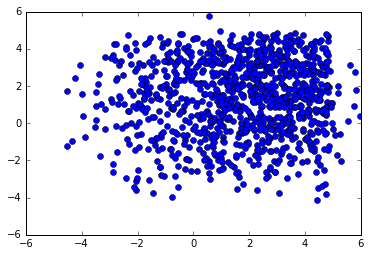

time: 191 ms


In [199]:
plt.plot(x, y, "o")
plt.show()

In [99]:
gap = np.random.uniform(0, 100, [2, 1024])
gag = np.zeros([2, 1024])
ov = np.zeros([2, 1024])
og = np.zeros([2, 1024])
nu = np.zeros([20, 1024])

time: 4.32 ms


In [150]:
np.sqrt((np.sum((l[1][2][0] - exp.env.gl[0])**2, axis = 0))).

12.292438000965172

time: 4.65 ms


In [101]:
gap_tensor = tf.constant(gap, tf.float32)
gag_tensor = tf.constant(gag, tf.float32)
ov_tensor = tf.constant(ov, tf.float32)
og_tensor = tf.constant(og, tf.float32)
nu_tensor = tf.constant(nu, tf.float32)
feed_dict = {exp.env.list_agents[0].tensor_goal_location: exp.env.gl[0], 
             exp.env.list_agents[0].tensor_goal_type:np.transpose(np.array([[1, 0, 0] for i in range(1024)]))}
res = exp.env.compute_reward_agents([gap_tensor], [gag_tensor], [ov_tensor], [nu_tensor])
sess.run(res, feed_dict)


[<tf.Tensor 'reward_computation_13/Neg:0' shape=(1024,) dtype=float32>]
Tensor("Mean_4:0", shape=(), dtype=float32)


-6680.5977

time: 231 ms


In [102]:
-np.mean(np.sum((gap - exp.env.gl[0])**2, axis = 0))

-6680.5959703852477

time: 3.91 ms


In [53]:
exp.feed_dict

{<tf.Tensor 'agent0/Placeholder_6:0' shape=(2, 1024) dtype=float32>: array([[-2.25,  0.58, -3.4 , ...,  4.96, -3.08,  3.95],
        [ 4.77,  0.9 , -2.87, ..., -1.09, -1.8 , -4.69]]),
 <tf.Tensor 'agent0/Placeholder_1:0' shape=(2, 1024) dtype=float32>: array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 <tf.Tensor 'agent0/Placeholder_7:0' shape=(3, 1024) dtype=float32>: array([[1, 1, 1, ..., 1, 1, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 <tf.Tensor 'agent0/Placeholder:0' shape=(2, 1024) dtype=float32>: array([[-4.17,  4.98, -2.81, ..., -4.68,  1.16,  4.49],
        [-2.15, -3.83, -2.22, ...,  1.45, -2.69, -1.2 ]]),
 <tf.Tensor 'agent0/Placeholder_3:0' shape=(20, 1024) dtype=float32>: array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.

time: 11.6 ms


In [469]:
e[2][0][:, 0]

array([   1.        ,    0.        ,    0.        ,    0.        ,
          0.5       ,   17.68958282,   24.84115028,  193.07865906], dtype=float32)

time: 3.77 ms


In [475]:
e[6][0][:, 1000]

array([   1.        ,    0.        ,    0.        ,    0.5       ,
          0.        ,   17.68958282,   24.84115028,  193.07865906], dtype=float32)

time: 3.5 ms


In [396]:
e = tf.constant(l[0][1][0])
ee = tf.gather_nd(e, exp.env.l3)

ValueError: Argument must be a dense tensor: [array([[ 3.59053731,  8.21302223,  3.32342291, ...,  5.74585104,
         4.84798861,  1.30313444],
       [ 8.06056118,  3.05529952,  4.10966778, ...,  0.43250307,
         0.17211625,  2.81950474]], dtype=float32)] - got shape [1, 2, 1024], but wanted [1].

time: 22.3 ms


In [394]:
uu = sess.run(ee)

NameError: name 'ee' is not defined

time: 9.79 ms


In [331]:
np.mean(np.sqrt(np.sum((l[-1][1][0] - np.ones((2, 1024)))**2, axis = 0)))

1.329129751505288

time: 4.87 ms


In [325]:
l[-1][1] - np.ones((2, 1024))

array([[[-0.94038602, -0.94031342, -0.94031677, ..., -0.94016784,
         -0.94046345, -0.94030191],
        [-0.93938235, -0.93933402, -0.93932448, ..., -0.93918149,
         -0.93951934, -0.93923045]]])

time: 3.33 ms


In [24]:
phys_net = PhysicalNet([2, 2], 2, output_size = 1)

time: 46.6 ms


In [40]:
phys_net = PhysicalNet([2], 2, output_size = 1)
c = tf.constant([[1.0], [1.0]])
init_op = tf.global_variables_initializer()
with tf.Session() as sess:
        sess.run(init_op)
        print(sess.run(phys_net.compute_output(c)))
        W = sess.run(phys_net.Weights[0])
        b = sess.run(phys_net.Biases[0])

[[-0.00048801]
 [ 0.00045316]]
time: 50.4 ms


In [45]:
np.dot(W, np.array([[1.0], [1.0]])) + b

array([[-0.00048801],
       [ 0.00045316]])

time: 4.09 ms


In [42]:
np.array([[1.0], [1.0]])

array([[ 1.],
       [ 1.]])

time: 6.73 ms


array([[-0.00065883],
       [ 0.00069445]], dtype=float32)

time: 4.35 ms


In [50]:
for i, j in zip([1, 2, 3], [4, 5, 6]):
    print(i,j)

1 4
2 5
3 6
time: 41.8 ms


In [71]:
d = {}
d["a"] = 3

time: 40.6 ms


In [72]:
d

{'a': 3}

time: 86.5 ms


In [74]:
for i, j in enumerate(zip([1, 2, 3], [4, 5, 6])):
    print(i,j)

0 (1, 4)
1 (2, 5)
2 (3, 6)
time: 4.08 ms


In [102]:
(1, 2, 3)[-1]

3

time: 15.8 ms


In [114]:
i0 = tf.constant(0)
m0 = tf.ones([2, 2])
c = lambda i, m: i < 10
b = lambda i, m: [i+1, tf.concat([m, m], axis=0)]
r = tf.while_loop(
    c, b, loop_vars=[i0, m0],
    shape_invariants=[i0.get_shape(), tf.TensorShape([None, 2])])


time: 29.9 ms


In [115]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(r))

[10, array([[ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       ..., 
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.]], dtype=float32)]
time: 158 ms


In [ ]:
np.ones((2, 3))

In [407]:
[1 for i in range(5) if i < 3 else 5]

SyntaxError: invalid syntax (<ipython-input-407-2066483bd6fe>, line 1)

In [409]:
for i in range(5):
    print([i for i in range(4)])

[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
time: 4.79 ms


In [31]:
u = tf.Variable([[-0.5, -1.0], [-1.0, -1.0]])
output = tf.nn.elu(u)

time: 12.8 ms


In [32]:
output

<tf.Tensor 'Elu_4:0' shape=(2, 2) dtype=float32>

time: 3.36 ms


In [33]:
init = tf.global_variables_initializer()
sess.run(init)
sess.run(output)

array([[-0.39346933, -0.63212055],
       [-0.63212055, -0.63212055]], dtype=float32)

time: 45.4 ms


In [286]:
l = [1, 2, 3]

time: 144 ms


In [288]:
l[0] = 4

time: 1.22 ms


In [289]:
l

[4, 2, 3]

time: 4.05 ms


In [77]:
np.transpose(np.array([[1, 0, 0] for i in range(1024)]))

(3, 1024)

time: 6.64 ms
